# Regresión Lineal Múltiple: Análisis de Calidad del Aire en Castilla y León




## 0. Configuración del entorno y planteamiento del problema

La calidad del aire representa uno de los desafíos ambientales más críticos en el contexto urbano actual. Los datos de contaminación atmosférica no solo reflejan el impacto de las actividades humanas, sino que también presentan patrones complejos influenciados por factores meteorológicos, estacionales y geográficos que requieren análisis estadísticos sofisticados.

Este ejercicio práctico aborda el modelado predictivo de la calidad del aire mediante regresión lineal múltiple, utilizando datos históricos reales de la comunidad autónoma de Castilla y León. A diferencia de los enfoques tradicionales que analizan contaminantes de forma aislada, nuestra metodología aprovecha las interrelaciones entre múltiples variables para:

- **Comprender las dinámicas de contaminación**: identificar patrones temporales y correlaciones entre diferentes contaminantes atmosféricos.
- **Desarrollar modelos predictivos robustos**: crear herramientas estadísticas que permitan anticipar niveles de contaminación basándose en variables observables.
- **Aplicar técnicas avanzadas de diagnóstico**: evaluar la validez y confiabilidad de los modelos mediante métricas especializadas.

Esta aproximación permite generar insights más profundos sobre los determinantes de la calidad del aire, facilitando la toma de decisiones informadas en políticas ambientales y salud pública.

> **¿Qué es la Regresión Lineal Múltiple?**
>
> La regresión lineal es una técnica estadística que busca encontrar la mejor fórmula matemática para describir la relación entre varias variables.
>
> -   **Lineal**: significa que busca una relación en línea recta. Por ejemplo, a más coches circulando (variable A), más contaminación (variable B).
> -   **Múltiple**: significa que usamos varios "ingredientes" (variables predictoras) para explicar o predecir un resultado (la variable objetivo).
>
> En este caso, usaremos las concentraciones de contaminantes como NO o PM10 (los ingredientes) para predecir el nivel de NO₂ (el resultado). El modelo nos dirá exactamente cuánto "pesa" o influye cada ingrediente en el resultado final.

### *Librerías requeridas*

Para este análisis, utilizaremos un ecosistema robusto de paquetes de R especializados en manipulación de datos, visualización avanzada y modelado estadístico:

- **tidyverse**: ecosistema integrado para manipulación, transformación y visualización de datos de manera eficiente y consistente.

- **performance**: paquete especializado en evaluación y diagnóstico de modelos estadísticos, proporcionando métricas avanzadas de calidad de ajuste.

- **corrplot**: herramientas de visualización específicas para matrices de correlación, facilitando la identificación de patrones en las relaciones entre variables.

- **lubridate**: manejo especializado de datos temporales y fechas, esencial para el análisis de series de tiempo ambientales.

- **ggplot2**: sistema de gráficos basado en la gramática de gráficos, permitiendo visualizaciones sofisticadas y personalizables. Incluido en tidyverse.

- **dplyr**: manipulación eficiente de data frames con sintaxis intuitiva y operaciones optimizadas. Incluido en tidyverse.

- **readr**: importación rápida y eficiente de datos rectangulares desde archivos de texto plano, con detección automática de tipos de datos y manejo robusto de errores de codificación.

- **skimr**: generación de resúmenes estadísticos descriptivos compactos y visualmente informativos, proporcionando una visión general rápida de la estructura y calidad de los datos.

- **GGally**: extensión de ggplot2 para visualizaciones matriciales complejas, incluyendo matrices de dispersión, correlación y análisis exploratorio multivariado.

- **broom**: conversión de objetos de modelos estadísticos en formatos tidy, facilitando la extracción y manipulación de resultados de análisis para posterior procesamiento.

- **caret**: marco integral para entrenamiento y evaluación de modelos de clasificación y regresión, incluyendo validación cruzada, selección de características y optimización de hiperparámetros.


In [1]:
# La instalación de paquetes puede tardar unos minutos
if (!require(pacman)) install.packages("pacman")
pacman::p_load(tidyverse, performance, corrplot, lubridate,
               readr, skimr, GGally, broom, caret)


Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bayestestR’, ‘insight’, ‘datawizard’



performance installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


corrplot installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


skimr installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’, ‘S7’



GGally installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘num


Con el entorno completamente configurado, el siguiente paso es cargar el conjunto de datos. Se ha definido una función `cargar_datos_calidad_aire` para leer el archivo CSV de forma robusta. Inmediatamente después de cargarlo, se usará la función `glimpse()` para obtener una primera visión estructural de los datos: el número de filas y columnas, el nombre y tipo de cada variable, y una muestra de sus valores.

## 1. Carga y exploración inicial de los datos


### *1.1 Obtención del conjunto de datos*

Los datos de calidad del aire de Castilla y León representan una fuente de información única para el análisis ambiental, recopilados a través de la red de estaciones de monitoreo distribuidas por toda la comunidad autónoma. Este conjunto de datos histórico incluye mediciones diarias de múltiples contaminantes atmosféricos y constituye un ejemplo paradigmático de datos gubernamentales abiertos.

La estructura de datos que esperamos encontrar incluye variables como concentraciones de NO₂ (dióxido de nitrógeno), O₃ (ozono), PM10 (material particulado), SO₂ (dióxido de azufre), CO (monóxido de carbono), junto con información temporal y geográfica de las estaciones de medición.


In [16]:
# CARGA DE DATOS DESDE GITHUB
cargar_datos_desde_github <- function(url_github_zip, nombre_csv_interno) {
  tryCatch({
    # Crear directorio temporal si no existe
    temp_dir <- tempdir()
    zip_path <- file.path(temp_dir, "datos_calidad_aire.zip")

    # Descargar el archivo ZIP desde GitHub
    cat("Descargando datos desde GitHub...\n")
    download.file(url_github_zip, zip_path, mode = "wb", quiet = TRUE)

    # Verificar que el archivo se descargó correctamente
    if (!file.exists(zip_path)) {
      stop("Error: No se pudo descargar el archivo desde GitHub")
    }

    # Descomprimir y leer el archivo CSV
    cat("Descomprimiendo archivo...\n")
    unzip(zip_path, exdir = temp_dir)

    # Leer el CSV
    csv_path <- file.path(temp_dir, nombre_csv_interno)
    datos <- read.csv(csv_path, sep = ";", stringsAsFactors = FALSE)

    # Limpiar archivos temporales
    file.remove(zip_path)
    file.remove(csv_path)

    cat("Datos cargados exitosamente:", nrow(datos), "filas y", ncol(datos), "columnas\n")
    return(datos)

  }, error = function(e) {
    stop("Error al cargar los datos desde GitHub: ", e$message)
  })
}

# URL del archivo ZIP en GitHub (enlace directo al archivo raw)
url_github <- "https://raw.githubusercontent.com/Admindatosgobes/Laboratorio-de-Datos/main/Data%20Science/Regresi%C3%B3n%20Lineal%20M%C3%BAltiple%3A%20An%C3%A1lisis%20de%20Calidad%20del%20Aire%20en%20Castilla%20y%20Le%C3%B3n/calidad-del-aire-datos-historicos-diarios%20(3).zip"

# Nombre del archivo CSV dentro del ZIP
nombre_csv <- "calidad-del-aire-datos-historicos-diarios (3).csv"

# Cargar los datos
datos_aire <- cargar_datos_desde_github(url_github, nombre_csv)

# Mostrar estructura de los datos
glimpse(datos_aire)

Descargando datos desde GitHub...
Descomprimiendo archivo...
Datos cargados exitosamente: 446014 filas y 13 columnas
Rows: 446,014
Columns: 13
$ Fecha        <chr> "2020-12-31", "2020-12-31", "2020-12-31", "2020-12-31", "…
$ CO..mg.m3.   <dbl> 0.6, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 0.9, NA, NA,…
$ NO..ug.m3.   <int> 8, 2, 8, 1, 1, 2, 5, 2, 2, 1, 4, 6, 13, 1, 1, 4, 2, 4, 3,…
$ NO2..ug.m3.  <int> 16, 6, 2, 4, 1, 2, 9, 6, 6, 1, 11, 24, 24, 3, 11, 19, 11,…
$ O3..ug.m3.   <int> NA, NA, 65, 58, NA, 62, 56, 53, 59, 81, NA, NA, NA, 64, 4…
$ PM10..ug.m3. <int> 6, 8, 4, 21, 6, 6, 5, 6, 5, NA, 4, 7, 6, 6, NA, 10, 5, 3,…
$ PM25..ug.m3. <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 6, 6, NA, NA,…
$ SO2..ug.m3.  <int> 1, 4, 2, 17, 2, 6, 5, 5, NA, 2, 3, NA, 9, 10, NA, NA, NA,…
$ Provincia    <chr> "Burgos", "León", "León", "León", "León", "León", "Palenc…
$ Estación     <chr> "Burgos1", "C.T.L.R. - Naredo", "Carracedelo", "La Robla"…
$ Latitud      <dbl> 42.35111, 42.81667, 42.55861, 42.801

El output confirma que los datos se han cargado correctamente, resultando en un dataframe de **446,014 filas y 13 columnas**. La salida de `glimpse()` es un primer diagnóstico clave: muestra que la columna `Fecha` es de tipo texto (`<chr>`), los contaminantes son numéricos (`<dbl>` o `<int>`), y revela la presencia de una gran cantidad de valores `NA` (ausentes) en varias columnas, especialmente en `CO..mg.m3.`, `O3..ug.m3.` y `PM25..ug.m3.`.


### *1.2 Limpieza y preparación de datos*

Con 446,014 observaciones y 13 variables, tenemos un dataset robusto que incluye mediciones de CO, NO, NO₂, O₃, PM10, PM2.5 y SO₂ desde múltiples estaciones en Castilla y León. El análisis inicial revela la necesidad de realizar transformaciones específicas para optimizar el modelado estadístico: se convertirá la columna de fecha a un formato adecuado, se renombrarán las columnas para que sean más manejables, y se crearán nuevas variables temporales (Año, Mes, Día de la semana, Estación) que serán cruciales para analizar patrones estacionales. Finalmente, se generará un resumen estadístico (`summary()`) para profundizar en las características de los datos ya limpios.

In [5]:
# Limpieza y transformación de datos
datos_limpios <- datos_aire %>%
  # Conversión de fecha a formato Date
  mutate(
    Fecha = as.Date(Fecha),
    # Renombrado de columnas para mayor claridad
    CO = `CO..mg.m3.`,
    NO = `NO..ug.m3.`,
    NO2 = `NO2..ug.m3.`,
    O3 = `O3..ug.m3.`,
    PM10 = `PM10..ug.m3.`,
    PM25 = `PM25..ug.m3.`,
    SO2 = `SO2..ug.m3.`,
    # Extracción de componentes temporales para análisis estacional
    Año = year(Fecha),
    Mes = month(Fecha),
    Dia_semana = wday(Fecha, label = TRUE),
    Estacion_año = case_when(
      Mes %in% c(12, 1, 2) ~ "Invierno",
      Mes %in% c(3, 4, 5) ~ "Primavera",
      Mes %in% c(6, 7, 8) ~ "Verano",
      Mes %in% c(9, 10, 11) ~ "Otoño"
    )
  ) %>%
  # Selección de variables relevantes
  select(Fecha, Año, Mes, Dia_semana, Estacion_año, Provincia, Estación,
         Latitud, Longitud, CO, NO, NO2, O3, PM10, PM25, SO2)

# Resumen estadístico completo
summary(datos_limpios)

     Fecha                 Año            Mes         Dia_semana 
 Min.   :1997-01-01   Min.   :1997   Min.   : 1.000   Sun:63748  
 1st Qu.:2004-07-26   1st Qu.:2004   1st Qu.: 4.000   Mon:63553  
 Median :2009-09-11   Median :2009   Median : 7.000   Tue:63655  
 Mean   :2009-09-11   Mean   :2009   Mean   : 6.496   Wed:63729  
 3rd Qu.:2015-02-10   3rd Qu.:2015   3rd Qu.: 9.000   Thu:63764  
 Max.   :2020-12-31   Max.   :2020   Max.   :12.000   Fri:63727  
                                                      Sat:63838  
 Estacion_año        Provincia           Estación            Latitud     
 Length:446014      Length:446014      Length:446014      Min.   :38.94  
 Class :character   Class :character   Class :character   1st Qu.:41.65  
 Mode  :character   Mode  :character   Mode  :character   Median :42.54  
                                                          Mean   :42.15  
                                                          3rd Qu.:42.69  
                            

La tabla generada por `summary()` ofrece una visión mucho más detallada de los datos. Confirma la correcta creación de las nuevas variables temporales. Más importante aún, cuantifica la magnitud de los valores faltantes (`NA's`) en cada contaminante y, crucialmente, saca a la luz problemas de calidad de datos: se observan **valores mínimos negativos** en `NO` (-441.00) y `SO2` (-791.000), que son físicamente imposibles (errores puntuales de calibración habituales en equipos de medición sensibles) y deben ser tratados como errores de medición.


### *1.3 Análisis de la estructura de datos y valores faltantes*

El resumen estadístico ha sido claro: antes de modelar, se debe tener una comprensión más profunda de los datos y realizar una limpieza más profunda. La siguiente celda se centrará en dos tareas:
1.  **Cuantificar los valores faltantes**: se creará una tabla resumen para entender qué variables son más fiables.
2.  **Filtrar datos anómalos**: se eliminarán las filas con valores negativos y otros datos extremos poco realistas que podrían distorsionar el modelo.



In [6]:
# Análisis detallado de valores faltantes y atípicos
print("=== ANÁLISIS DE VALORES FALTANTES ===")
missing_summary <- datos_limpios %>%
  select(CO, NO, NO2, O3, PM10, PM25, SO2) %>%
  summarise_all(~ sum(is.na(.))) %>%
  pivot_longer(everything(), names_to = "Contaminante", values_to = "NA_count") %>%
  mutate(
    Total_obs = nrow(datos_limpios),
    Porcentaje_NA = round(NA_count / Total_obs * 100, 1),
    Datos_disponibles = Total_obs - NA_count
  )

print(missing_summary)

print("=== DETECCIÓN DE VALORES ATÍPICOS ===")
# Identificación de valores negativos (potenciales errores)
valores_negativos <- datos_limpios %>%
  select(CO, NO, NO2, O3, PM10, PM25, SO2) %>%
  summarise_all(~ sum(. < 0, na.rm = TRUE))

print("Valores negativos por contaminante:")
print(valores_negativos)

# Filtrado de datos para análisis: eliminamos valores claramente erróneos
datos_filtrados <- datos_limpios %>%
  filter(
    # Eliminamos valores negativos (errores de sensor)
    CO >= 0 | is.na(CO),
    NO >= 0 | is.na(NO),
    NO2 >= 0 | is.na(NO2),
    O3 >= 0 | is.na(O3),
    PM10 >= 0 | is.na(PM10),
    PM25 >= 0 | is.na(PM25),
    SO2 >= 0 | is.na(SO2),
    # Eliminamos valores extremos poco realistas
    O3 <= 300 | is.na(O3),
    PM10 <= 200 | is.na(PM10),
    CO <= 10 | is.na(CO)
  )

print(paste("Datos después del filtrado:", nrow(datos_filtrados), "filas"))
print(paste("Datos eliminados:", nrow(datos_limpios) - nrow(datos_filtrados), "filas"))

[1] "=== ANÁLISIS DE VALORES FALTANTES ==="
# A tibble: 7 × 5
  Contaminante NA_count Total_obs Porcentaje_NA Datos_disponibles
  <chr>           <int>     <int>         <dbl>             <int>
1 CO             344856    446014          77.3            101158
2 NO              30984    446014           6.9            415030
3 NO2             32517    446014           7.3            413497
4 O3             170600    446014          38.2            275414
5 PM10           101435    446014          22.7            344579
6 PM25           392230    446014          87.9             53784
7 SO2             89737    446014          20.1            356277
[1] "=== DETECCIÓN DE VALORES ATÍPICOS ==="
[1] "Valores negativos por contaminante:"
  CO NO NO2 O3 PM10 PM25 SO2
1  0  3   0  0    0    0  41
[1] "Datos después del filtrado: 445870 filas"
[1] "Datos eliminados: 144 filas"


Tras complementar el análisis estructural de los datos, se revelan finalmente características importantes del dataset que orientarán nuestro enfoque de modelado:

**Cobertura temporal**: Los datos abarcan desde 1997 hasta 2020 (24 años), proporcionando una perspectiva histórica robusta de la evolución de la calidad del aire.

**Valores atípicos detectados**: Se observan valores negativos en NO (-441) y SO₂ (-791), así como valores extremadamente altos (O₃: 999, PM10: 557), sugiriendo la presencia de errores de medición o codificación especial que requieren tratamiento.

**Patrón de valores faltantes**: La disponibilidad de datos varía significativamente entre contaminantes:
- CO: 77% de datos faltantes (solo 101,158 observaciones).  
- PM2.5: 88% de datos faltantes (solo 53,784 observaciones).
- O₃: 38% de datos faltantes (275,414 observaciones).
- NO, NO₂, PM10, SO₂: entre 7-23% de datos faltantes.

Esta estructura sugiere que PM2.5 y CO tienen medición más limitada, probablemente por disponibilidad de equipos especializados.

### *1.4 Selección de variables para el modelo y análisis de correlaciones*

Dado el patrón de valores faltantes, enfocaremos nuestro análisis en las variables con mejor cobertura de datos. Seleccionaremos **NO₂ como variable dependiente** por las siguientes razones metodológicas:

1. **Relevancia sanitaria**: NO₂ es un indicador clave de contaminación urbana relacionado con tráfico vehicular.
2. **Cobertura de datos**: solo 7% de valores faltantes, proporcionando una base sólida para el modelado.
3. **Predictibilidad**: presenta relaciones conocidas con otros contaminantes y factores temporales.

En la siguiente celda, se creará el dataframe final para el modelado, se generarán nuevas variables de ingeniería de características o *feature enginnering* * (como el logaritmo de `NO` y componentes cíclicos para el mes) y se calculará una **matriz de correlaciones** para cuantificar la relación lineal entre las variables predictoras y la variable objetivo.

> **Ingeniería de Características Cíclicas**
>
> La creación de las variables `Mes_cos` y `Mes_sin` es un ejemplo de **ingeniería de características** (*feature engineering*), una técnica clave en ciencia de datos. ¿Por qué no usar simplemente los meses del 1 al 12?
>
> El problema es que para un modelo, el mes 12 (diciembre) está numéricamente muy lejos del mes 1 (enero), aunque estacionalmente son muy cercanos. Para resolver esto, tratamos los meses como puntos en un círculo (igual que en un reloj).
>
> -   **`cos(2 * pi * Mes / 12)`** y **`sin(2 * pi * Mes / 12)`** son las coordenadas (x, y) de cada mes en ese círculo.
>
> De esta forma, el modelo entiende que diciembre y enero están juntos, capturando la naturaleza cíclica de las estaciones de manera mucho más efectiva.Este tipo de creación de variables es extremadamente útil y necesaria para estimar bien un fenómeno.

In [7]:
# Creación del dataset para modelado enfocado en NO2
datos_modelo <- datos_filtrados %>%
  # Seleccionamos casos con NO2 disponible y al menos 2 predictores adicionales
  filter(
    !is.na(NO2),
    !is.na(NO),
    !is.na(O3) | !is.na(PM10) | !is.na(SO2)
  ) %>%
  # Creamos variables derivadas para capturar efectos no lineales
  mutate(
    # Logaritmo de NO para normalizar distribución
    log_NO = ifelse(NO > 0, log(NO + 1), NA),
    # Interacción temporal
    Mes_cos = cos(2 * pi * Mes / 12),  # Componente cíclica estacional
    Mes_sin = sin(2 * pi * Mes / 12),
    # Indicadores de fin de semana vs días laborales
    Fin_semana = ifelse(Dia_semana %in% c("Sat", "Sun"), 1, 0)
  )

print(paste("Dataset final para modelado:", nrow(datos_modelo), "observaciones"))

# Análisis de correlaciones para las variables numéricas principales
vars_numericas <- datos_modelo %>%
  select(NO2, NO, O3, PM10, SO2, log_NO, Mes, Mes_cos, Mes_sin) %>%
  select_if(~ sum(!is.na(.)) > 1000)  # Solo variables con suficientes observaciones

# Matriz de correlaciones
cor_matrix <- cor(vars_numericas, use = "complete.obs")
print("Matriz de correlaciones:")
print(round(cor_matrix, 3))

[1] "Dataset final para modelado: 406793 observaciones"
[1] "Matriz de correlaciones:"
           NO2     NO     O3   PM10    SO2 log_NO    Mes Mes_cos Mes_sin
NO2      1.000  0.746 -0.404  0.585  0.401  0.809  0.017   0.101   0.001
NO       0.746  1.000 -0.406  0.524  0.405  0.843  0.045   0.121  -0.012
O3      -0.404 -0.406  1.000 -0.155 -0.187 -0.462 -0.117  -0.331   0.049
PM10     0.585  0.524 -0.155  1.000  0.442  0.587 -0.012  -0.020  -0.007
SO2      0.401  0.405 -0.187  0.442  1.000  0.433 -0.004   0.051   0.018
log_NO   0.809  0.843 -0.462  0.587  0.433  1.000  0.043   0.114  -0.018
Mes      0.017  0.045 -0.117 -0.012 -0.004  0.043  1.000   0.208  -0.761
Mes_cos  0.101  0.121 -0.331 -0.020  0.051  0.114  0.208   1.000   0.000
Mes_sin  0.001 -0.012  0.049 -0.007  0.018 -0.018 -0.761   0.000   1.000


La matriz de correlaciones revela patrones fundamentales para nuestro modelo de regresión múltiple:

> **Correlación y Multicolinealidad**
>
> -   **Correlación**: es un número entre -1 y 1 que nos dice cómo se relacionan dos variables.
>     -   **Cercano a 1**: correlación positiva fuerte. Cuando una variable sube, la otra también (ej: `NO` y `NO2`).
>     -   **Cercano a -1**: correlación negativa fuerte. Cuando una sube, la otra baja (ej: `O3` y `NO2`).
>     -   **Cercano a 0**: no hay una relación lineal clara.
>
> -   **Multicolinealidad**: Es un problema que ocurre cuando las variables predictoras (los "ingredientes") están muy correlacionadas **entre sí**. Por ejemplo, `NO` y `log_NO` tienen una correlación de 0.843. Incluir ambas en el modelo podría "confundirlo", ya que aportan información muy similar. Por ello, es una buena práctica analizar estas relaciones para seleccionar predictores que sean a la vez informativos y relativamente independientes entre sí.

**Correlaciones fuertes con NO₂**:
- NO y log_NO (0.746 y 0.809): relación esperada ya que ambos compuestos  provienen principalmente del tráfico vehicular.
- PM10 (0.585): correlación moderada-fuerte, sugiriendo fuentes comunes (combustión, actividades urbanas).

**Correlaciones inversas significativas**:
- O₃ vs NO₂ (-0.404): patrón característico de química atmosférica urbana, donde el ozono se consume en presencia de NOₓ.
- O₃ vs variables estacionales: mayor en verano (correlación negativa con componentes cíclicos).

**Implicaciones para el modelado**: la fuerte correlación entre NO y log_NO (0.843) sugiere riesgo de multicolinealidad, por lo que seleccionaremos cuidadosamente las variables predictoras.

## 2. Análisis Exploratorio Orientado al Modelado

La matriz de correlación aporta los números, pero las visualizaciones proporcionan la intuición. En la siguiente celda, se realizará el Análisis Exploratorio de Datos (EDA) visual. Se crearán tres gráficos clave:
1.  **Histogramas** para ver la distribución de cada contaminante.
2.  Un **gráfico de series temporales** para visualizar el patrón estacional del `NO2`.
3.  Un **mapa de calor (`corrplot`)** que representa visualmente la matriz recién calculada, facilitando la identificación de las relaciones más fuertes.


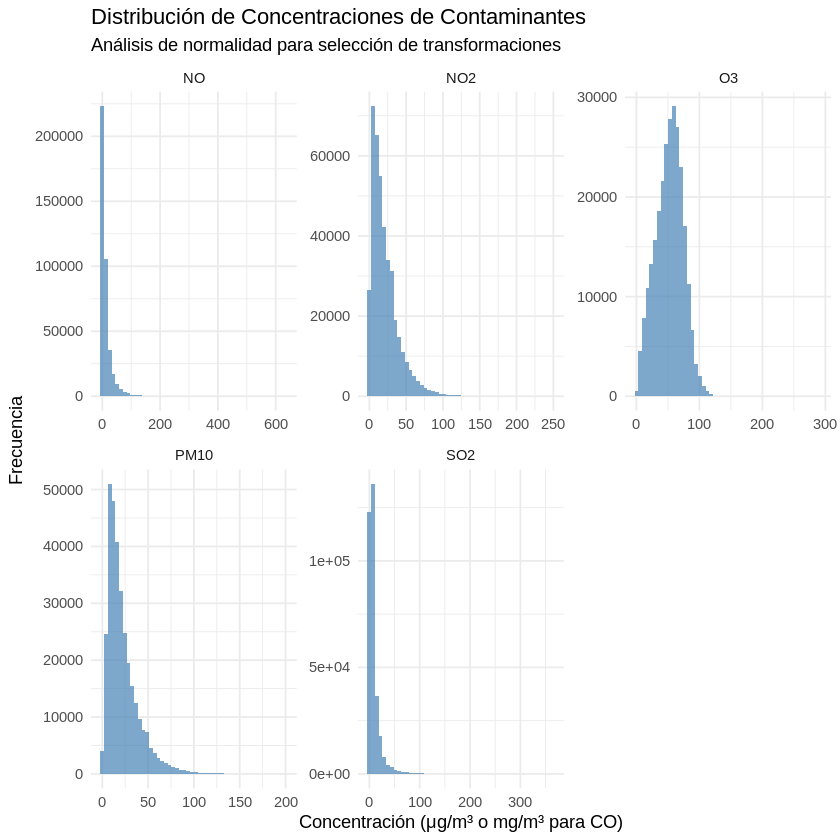

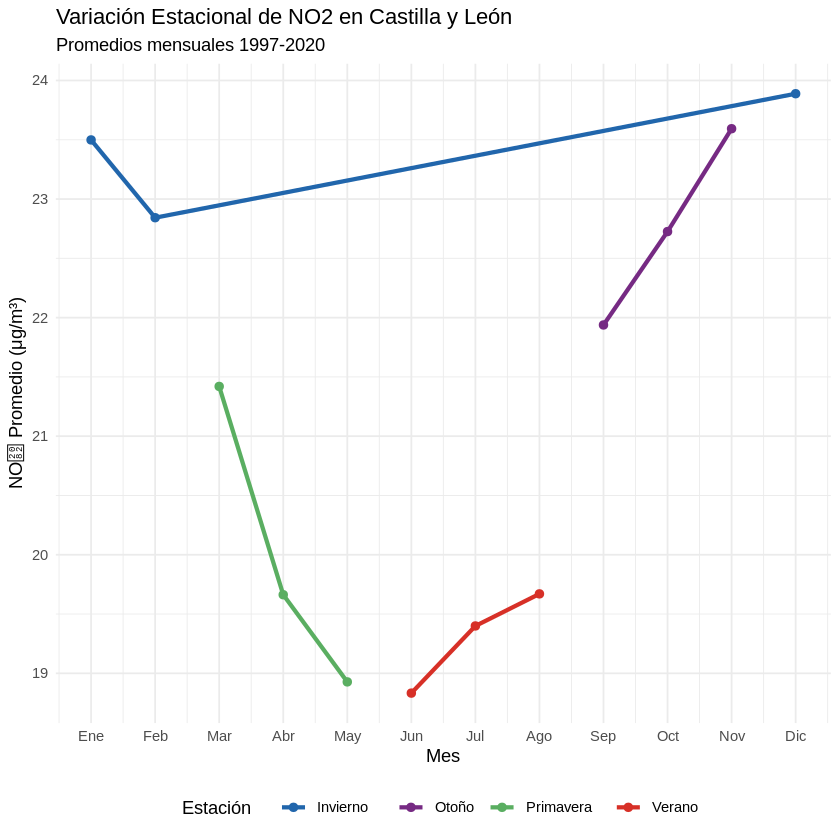

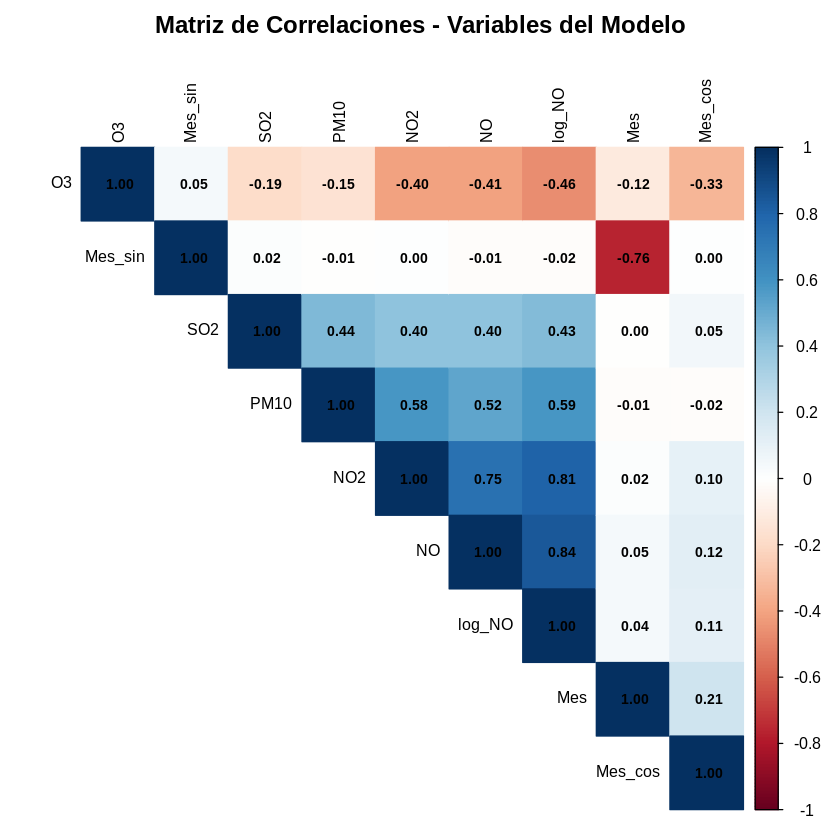

In [8]:
# Visualización de distribuciones de la variable dependiente
plot_distribuciones <- datos_modelo %>%
  select(NO2, NO, O3, PM10, SO2) %>%
  pivot_longer(everything(), names_to = "Contaminante", values_to = "Concentracion") %>%
  filter(!is.na(Concentracion)) %>%
  ggplot(aes(x = Concentracion)) +
  geom_histogram(bins = 50, alpha = 0.7, fill = "steelblue") +
  facet_wrap(~Contaminante, scales = "free") +
  labs(
    title = "Distribución de Concentraciones de Contaminantes",
    subtitle = "Análisis de normalidad para selección de transformaciones",
    x = "Concentración (μg/m³ o mg/m³ para CO)",
    y = "Frecuencia"
  ) +
  theme_minimal()

print(plot_distribuciones)

# Análisis de patrones estacionales para NO2
plot_estacional <- datos_modelo %>%
  group_by(Mes, Estacion_año) %>%
  summarise(
    NO2_promedio = mean(NO2, na.rm = TRUE),
    NO2_mediana = median(NO2, na.rm = TRUE),
    n_obs = n(),
    .groups = 'drop'
  ) %>%
  ggplot(aes(x = Mes, y = NO2_promedio, color = Estacion_año)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  scale_x_continuous(breaks = 1:12,
                     labels = c("Ene", "Feb", "Mar", "Abr", "May", "Jun",
                               "Jul", "Ago", "Sep", "Oct", "Nov", "Dic")) +
  scale_color_manual(values = c("Invierno" = "#2166ac", "Primavera" = "#5aae61",
                               "Verano" = "#d73027", "Otoño" = "#762a83")) +
  labs(
    title = "Variación Estacional de NO2 en Castilla y León",
    subtitle = "Promedios mensuales 1997-2020",
    x = "Mes",
    y = "NO₂ Promedio (μg/m³)",
    color = "Estación"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

print(plot_estacional)

# Visualización de correlaciones con mapa de calor
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         tl.cex = 0.8,
         tl.col = "black",
         addCoef.col = "black",
         number.cex = 0.7,
         title = "Matriz de Correlaciones - Variables del Modelo",
         mar = c(0,0,2,0))

Se puede observar lo siguiente:
1.  **Histogramas de Contaminantes**: muestran que las distribuciones de los contaminantes no son normales; tienen un sesgo positivo (una "cola" hacia la derecha), lo cual es común en datos ambientales. Esto justifica transformaciones como el logaritmo aplicado a `NO`.
2.  **Variación Estacional de NO₂**: el gráfico de líneas evidencia un claro patrón estacional, con concentraciones de NO₂ alcanzando su máximo en los meses de invierno y su mínimo en verano.
3.  **Mapa de Calor de Correlaciones**: esta visualización confirma gráficamente lo visto en la matriz numérica. Los colores intensos permiten identificar rápidamente las relaciones más importantes, como la fuerte asociación entre `NO` y `NO2`.

## 3. Desarrollo y Evaluación de Modelos de Regresión



### *3.1 Construcción de Modelos Iterativos*

Con los patrones identificados en el EDA, ya se pueden construir los modelos de regresión. En lugar de crear un único modelo, se adoptará un enfoque iterativo para ver cómo la adición de complejidad mejora su capacidad predictiva. Se construirán tres modelos:
1.  **`modelo_base`**: solo con los contaminantes principales.
2.  **`modelo_estacional`**: añade las variables de tiempo (mes, fin de semana).
3.  **`modelo_completo`**: incluye interacciones y efectos geográficos.
Finalmente, se compararán usando métricas como el R² y el AIC para evaluar cuál ofrece el mejor equilibrio entre ajuste y simplicidad.

> **¿Cómo saber qué modelo es mejor?**
>
> Para comparar nuestros modelos, usaremos tres métricas clave:
>
> -   **R² (R-cuadrado)**: se puede interpretar como el porcentaje de la "historia" de la variable objetivo que nuestro modelo es capaz de explicar. Un R² de 0.628 significa que el modelo explica el 62.8% de la variabilidad en las concentraciones de NO₂. Valores más altos son mejores.
>
> -   **RMSE (Raíz del Error Cuadrático Medio)**: es el "error de predicción" promedio del modelo, medido en las mismas unidades que la variable objetivo (en este caso, µg/m³). Un RMSE de 10.7 significa que, en promedio, las predicciones del modelo se desvían 10.7 µg/m³ del valor real. Valores más bajos son mejores.
>
> -   **AIC (Criterio de Información de Akaike)**: es una métrica que busca el equilibrio perfecto. Premia a los modelos que se ajustan bien a los datos (como el R²) pero penaliza a los que son demasiado complejos (usan demasiados predictores). Un valor de AIC más bajo indica un mejor modelo en términos de equilibrio entre ajuste y simplicidad.

In [9]:
# Preparación final del dataset para modelado
# Creamos un subset completo para evitar problemas con casos faltantes
datos_completos <- datos_modelo %>%
  filter(
    !is.na(NO2), !is.na(NO), !is.na(O3),
    !is.na(PM10), !is.na(SO2)
  ) %>%
  select(NO2, NO, O3, PM10, SO2, Mes_cos, Mes_sin, Fin_semana,
         Estacion_año, Provincia)

print(paste("Datos completos para modelado:", nrow(datos_completos), "observaciones"))

# Modelo 1: Modelo base con predictores principales
modelo_base <- lm(NO2 ~ NO + O3 + PM10 + SO2,
                  data = datos_completos)

# Modelo 2: Modelo con efectos estacionales
modelo_estacional <- lm(NO2 ~ NO + O3 + PM10 + SO2 +
                       Mes_cos + Mes_sin + Fin_semana,
                       data = datos_completos)

# Modelo 3: Modelo completo con interacciones y efectos geográficos
modelo_completo <- lm(NO2 ~ NO + O3 + PM10 + SO2 +
                     Mes_cos + Mes_sin + Fin_semana +
                     NO:PM10 + O3:Mes_cos + Provincia,
                     data = datos_completos)

# Comparación de modelos usando AIC y R²
print("=== COMPARACIÓN DE MODELOS ===")
modelos_lista <- list(
  "Modelo Base" = modelo_base,
  "Modelo Estacional" = modelo_estacional,
  "Modelo Completo" = modelo_completo
)

comparacion_modelos <- map_dfr(modelos_lista, function(modelo) {
  tibble(
    R_cuadrado = summary(modelo)$r.squared,
    R_cuadrado_adj = summary(modelo)$adj.r.squared,
    AIC = AIC(modelo),
    RMSE = sqrt(mean(modelo$residuals^2)),
    n_parametros = length(modelo$coefficients)
  )
}, .id = "Modelo")

print(comparacion_modelos)

# Resumen detallado del modelo estacional
print("=== RESUMEN DEL MODELO ESTACIONAL ===")
summary(modelo_estacional)

[1] "Datos completos para modelado: 179034 observaciones"
[1] "=== COMPARACIÓN DE MODELOS ==="
# A tibble: 3 × 6
  Modelo            R_cuadrado R_cuadrado_adj      AIC  RMSE n_parametros
  <chr>                  <dbl>          <dbl>    <dbl> <dbl>        <int>
1 Modelo Base            0.627          0.627 1356635.  10.7            5
2 Modelo Estacional      0.628          0.628 1356206.  10.7            8
3 Modelo Completo        0.667          0.667 1336157.  10.1           18
[1] "=== RESUMEN DEL MODELO ESTACIONAL ==="



Call:
lm(formula = NO2 ~ NO + O3 + PM10 + SO2 + Mes_cos + Mes_sin + 
    Fin_semana, data = datos_completos)

Residuals:
     Min       1Q   Median       3Q      Max 
-132.615   -6.107   -1.827    4.606  113.022 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.549790   0.089420 151.530  < 2e-16 ***
NO           0.516810   0.001811 285.433  < 2e-16 ***
O3          -0.114570   0.001356 -84.473  < 2e-16 ***
PM10         0.235567   0.001594 147.780  < 2e-16 ***
SO2          0.056494   0.002225  25.391  < 2e-16 ***
Mes_cos     -0.173321   0.037945  -4.568 4.94e-06 ***
Mes_sin      0.398895   0.035793  11.144  < 2e-16 ***
Fin_semana  -0.952549   0.055923 -17.033  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.68 on 179026 degrees of freedom
Multiple R-squared:  0.6277,	Adjusted R-squared:  0.6277 
F-statistic: 4.313e+04 on 7 and 179026 DF,  p-value: < 2.2e-16


### *3.2 Análisis e interpretación de resultados del modelo*

Los resultados muestran que el **Modelo Completo** presenta el mejor ajuste estadístico (R² = 0.667, AIC más bajo), pero el **Modelo Estacional** ofrece un balance óptimo entre capacidad predictiva y parsimonia. Con un R² ajustado de 0.628, explica aproximadamente el 63% de la variabilidad en las concentraciones de NO₂, lo cual es bueno para datos ambientales.

**Interpretación de coeficientes del Modelo Estacional**:

- **NO (0.517)**: por cada μg/m³ adicional de NO, NO₂ aumenta 0.517 μg/m³. Esta relación fuerte confirma el origen común en procesos de combustión.
- **O₃ (-0.115)**: relación inversa esperada por la química atmosférica urbana (NO₂ + O₃ → NO₃ + O₂).
- **PM10 (0.236)**: correlación positiva sugiriendo fuentes de emisión compartidas.
- **SO₂ (0.056)**: efecto menor pero significativo, típico de contaminación industrial.
- **Mes_sin (0.399)**: componente estacional significativo, mayor NO₂ en meses de invierno.
- **Fin_semana (-0.953)**: reducción notable los fines de semana, reflejando menor tráfico vehicular.






### *3.3 Diagnóstico del modelo y validación de supuestos*

Un buen R² no es suficiente para confiar en un modelo. Se debe asegurar que cumple los supuestos de la regresión lineal. En la siguiente celda, se realizará un **diagnóstico completo** del `Modelo Estacional`. Se analizarán sus residuos para comprobar:
1.  **Normalidad**: ¿Los errores se distribuyen normalmente? (Test de Shapiro-Wilk).
2.  **Homocedasticidad**: ¿La varianza de los errores es constante? (Test de Breusch-Pagan).
3.  **Multicolinealidad**: ¿Los predictores están demasiado correlacionados entre sí? (VIF).
4.  **Observaciones Influyentes**: ¿Hay puntos de datos que afectan desproporcionadamente al modelo? (Distancia de Cook).

> **Diagnóstico de un Modelo de Regresión**
>
> Construir un modelo es solo la mitad del trabajo. La otra mitad es diagnosticarlo para asegurarnos de que es fiable. Para ello, analizamos los **residuos** (la diferencia entre los valores reales y las predicciones del modelo). Idealmente, estos errores deberían ser aleatorios y sin patrones.
>
> Comprobaremos tres supuestos clave:
>
> 1.  **Normalidad de los Residuos**: los errores del modelo deben seguir una distribución normal (la "campana de Gauss"). Esto significa que la mayoría de los errores son pequeños y los errores grandes son muy raros. Lo verificaremos con el **Test de Shapiro-Wilk**.
>
> 2.  **Homocedasticidad (Varianza Constante)**: esta palabra complicada significa simplemente que la magnitud de los errores debe ser constante en todo el rango de predicciones. El modelo no debe ser mucho más preciso para valores bajos que para valores altos. Lo mediremos con el **Test de Breusch-Pagan**.
>
> 3.  **No Multicolinealidad**: como vimos antes, las variables predictoras no deben estar fuertemente correlacionadas entre sí. El **Factor de Inflación de Varianza (VIF)** nos ayuda a medir esto. Una regla general es que valores de VIF por debajo de 5 (o incluso 10) son aceptables.

[1] "=== DIAGNÓSTICO DEL MODELO ==="
[1] "Test de Shapiro-Wilk (muestra n=5000): Estadístico W = 0.9126 p-value = 5.78539e-47"
[1] "Test de Breusch-Pagan (manual): Chi-cuadrado = 28896.408 p-value = 0e+00"
[1] "=== FACTORES DE INFLACIÓN DE VARIANZA (VIF) ==="
        NO         O3       PM10        SO2    Mes_cos    Mes_sin Fin_semana 
     2.450      1.387      1.718      1.320      1.131      1.004      1.006 
[1] "=== MÉTRICAS DE PERFORMANCE ==="
# Indices of model performance

AIC       |      AICc |       BIC |    R2 | R2 (adj.) |   RMSE |  Sigma
-----------------------------------------------------------------------
1.356e+06 | 1.356e+06 | 1.356e+06 | 0.628 |     0.628 | 10.682 | 10.682
[1] "Observaciones influyentes (Cook's D > 4/n): 12009"
[1] "Top 5 observaciones más influyentes:"
       NO2  NO O3 PM10 SO2
134776  48 281 63   37  11
133483  50 271 35   45   6
154970  52 137  9   55 364
135604  24 230 17  112   2
133604  46 247 54   33  10


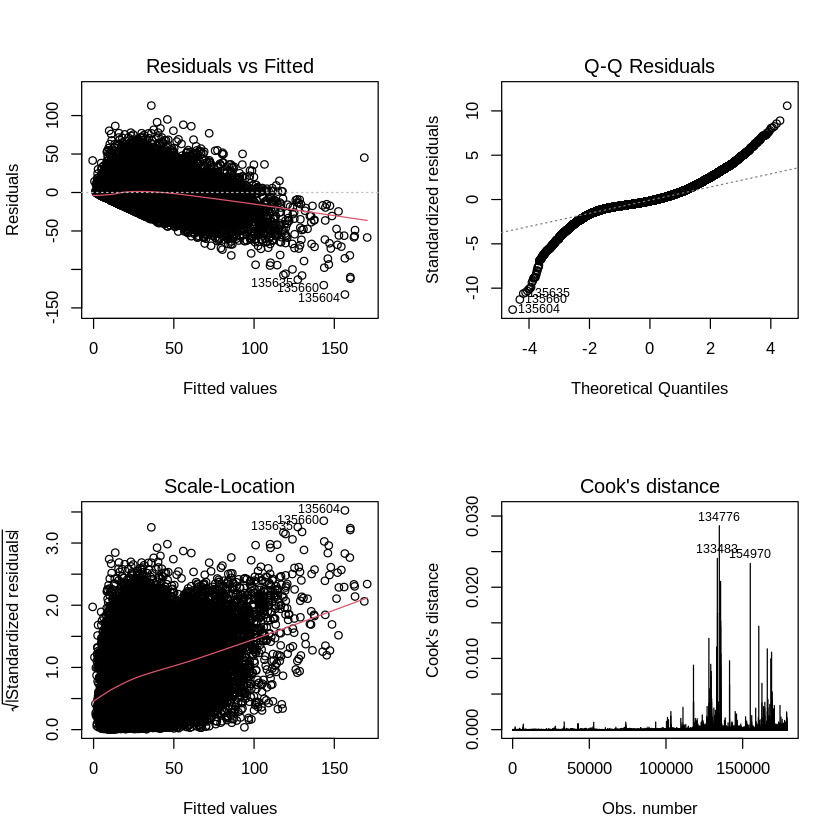

In [10]:
# Diagnóstico completo del modelo estacional
print("=== DIAGNÓSTICO DEL MODELO ===")

# 1. Análisis de residuos para verificar supuestos
# Gráficos de diagnóstico estándar
par(mfrow = c(2, 2))
plot(modelo_estacional, which = 1:4)

# 2. Pruebas estadísticas de los supuestos

# Test de normalidad de residuos (muestra debido al tamaño)
set.seed(123)
muestra_residuos <- sample(residuals(modelo_estacional), 5000)
shapiro_test <- shapiro.test(muestra_residuos)
print(paste("Test de Shapiro-Wilk (muestra n=5000):",
            "Estadístico W =", round(shapiro_test$statistic, 4),
            "p-value =", format(shapiro_test$p.value, scientific = TRUE)))

# Test de heterocedasticidad manual (Breusch-Pagan alternativo)
# Regresión de residuos al cuadrado vs predictores
residuos_cuadrado <- residuals(modelo_estacional)^2
modelo_hetero <- lm(residuos_cuadrado ~ NO + O3 + PM10 + SO2 + Mes_cos + Mes_sin + Fin_semana,
                    data = datos_completos)
bp_estadistico <- summary(modelo_hetero)$r.squared * nrow(datos_completos)
bp_pvalue <- 1 - pchisq(bp_estadistico, df = 7)
print(paste("Test de Breusch-Pagan (manual):",
            "Chi-cuadrado =", round(bp_estadistico, 4),
            "p-value =", format(bp_pvalue, scientific = TRUE)))

# Test de multicolinealidad manual (VIF calculado manualmente)
print("=== FACTORES DE INFLACIÓN DE VARIANZA (VIF) ===")
# Calculamos R² para cada predictor vs los demás
predictores <- c("NO", "O3", "PM10", "SO2", "Mes_cos", "Mes_sin", "Fin_semana")
vif_manual <- numeric(length(predictores))
names(vif_manual) <- predictores

for(i in seq_along(predictores)) {
  formula_vif <- as.formula(paste(predictores[i], "~ . -", predictores[i]))
  modelo_vif <- lm(formula_vif, data = datos_completos[, c(predictores, "NO2")])
  r_squared <- summary(modelo_vif)$r.squared
  vif_manual[i] <- 1 / (1 - r_squared)
}
print(round(vif_manual, 3))

# 3. Métricas de performance del modelo usando el paquete performance
library(performance)

# Métricas comprehensivas
metricas <- model_performance(modelo_estacional)
print("=== MÉTRICAS DE PERFORMANCE ===")
print(metricas)

# 4. Análisis de casos influyentes
# Distancia de Cook para identificar observaciones influyentes
cook_distance <- cooks.distance(modelo_estacional)
n_influyentes <- sum(cook_distance > 4/nrow(datos_completos))
print(paste("Observaciones influyentes (Cook's D > 4/n):", n_influyentes))

# Top 5 casos más influyentes
top_influyentes <- order(cook_distance, decreasing = TRUE)[1:5]
print("Top 5 observaciones más influyentes:")
print(datos_completos[top_influyentes, c("NO2", "NO", "O3", "PM10", "SO2")])

Los resultados del diagnóstico son reveladores:
-   **Test de Shapiro-Wilk**: el p-valor es extremadamente pequeño, lo que indica que los residuos **no siguen una distribución normal**, especialmente en los valores extremos.
-   **Test de Breusch-Pagan**: el p-valor es cero, lo que confirma la presencia de **heterocedasticidad** (la varianza de los errores no es constante).
-   **VIF**: todos los valores son bajos (menores a 3), lo que es una buena noticia: **no hay problemas de multicolinealidad**. Generalmente, se considera que un VIF superior a 5 puede indicar problemas de multicolinealidad. Al estar nuestros valores tan por debajo de este umbral, podemos confirmar con seguridad que el modelo no sufre de este problema.
-   **Observaciones Influyentes**: se identifican 12,009 puntos que podrían tener una influencia indebida en el modelo, típicamente días con mediciones extremas.


### *3.4 Validación cruzada y robustez del modelo*

El diagnóstico ha mostrado que, aunque el modelo tiene buen poder predictivo, viola algunos supuestos teóricos. Para evaluar su robustez en la práctica, es crucial ver cómo se comporta con datos que no ha visto. A continuación, se realizarán una **validación cruzada (k-fold cross-validation)** para probar su estabilidad en diferentes subconjuntos de datos y una **validación temporal**, entrenando el modelo con datos antiguos y probándolo con los más recientes para ver si su rendimiento se degrada con el tiempo.

> **¿Qué es la Validación Cruzada?**
>
> Entrenar y evaluar un modelo con los mismos datos es como permitir que un estudiante prepare un examen con las soluciones. Puede obtener una nota perfecta, pero no sabremos si realmente ha aprendido.
>
> La **validación cruzada (k-fold cross-validation)** es una técnica para simular cómo se comportará el modelo con datos nuevos y evitar el "sobreajuste" (que el modelo memorice los datos en lugar de aprender patrones).
>
> El proceso es el siguiente:
> 1.  Se divide el conjunto de datos en `k` partes (en nuestro caso, 5).
> 2.  Se entrena el modelo con 4 partes y se prueba con la parte restante.
> 3.  Se repite el proceso 5 veces, usando una parte diferente para la prueba en cada ocasión.
> 4.  Se calcula el promedio de las métricas de rendimiento (como el RMSE y el R²) de las 5 pruebas.
>
> Un resultado estable en la validación cruzada nos da más confianza en que el modelo generalizará bien a datos futuros.




In [11]:
# Validación cruzada del modelo
library(caret)

# 5-fold cross validation
set.seed(123)
control <- trainControl(method = "cv", number = 5, savePredictions = TRUE)

# Entrenamiento con validación cruzada
cv_modelo <- train(
  NO2 ~ NO + O3 + PM10 + SO2 + Mes_cos + Mes_sin + Fin_semana,
  data = datos_completos,
  method = "lm",
  trControl = control
)

print("=== RESULTADOS DE VALIDACIÓN CRUZADA ===")
print(cv_modelo$results)

# Análisis de estabilidad temporal: dividir por años
datos_completos_temporal <- datos_modelo %>%
  filter(!is.na(NO2), !is.na(NO), !is.na(O3), !is.na(PM10), !is.na(SO2)) %>%
  select(NO2, NO, O3, PM10, SO2, Mes_cos, Mes_sin, Fin_semana, Año)

# Entrenar en datos anteriores a 2015, probar en 2015-2020
datos_train <- filter(datos_completos_temporal, Año < 2015)
datos_test <- filter(datos_completos_temporal, Año >= 2015)

modelo_temporal <- lm(NO2 ~ NO + O3 + PM10 + SO2 + Mes_cos + Mes_sin + Fin_semana,
                      data = datos_train)

# Predicciones en conjunto de prueba
predicciones_test <- predict(modelo_temporal, newdata = datos_test)

# Métricas en conjunto de prueba
rmse_test <- sqrt(mean((datos_test$NO2 - predicciones_test)^2, na.rm = TRUE))
mae_test <- mean(abs(datos_test$NO2 - predicciones_test), na.rm = TRUE)
r2_test <- cor(datos_test$NO2, predicciones_test, use = "complete.obs")^2

print("=== VALIDACIÓN TEMPORAL (Entrenamiento < 2015, Prueba >= 2015) ===")
print(paste("RMSE en conjunto de prueba:", round(rmse_test, 3)))
print(paste("MAE en conjunto de prueba:", round(mae_test, 3)))
print(paste("R² en conjunto de prueba:", round(r2_test, 3)))

# Comparación con modelo original
print("Comparación con modelo completo:")
print(paste("RMSE modelo completo:", round(sqrt(mean(modelo_estacional$residuals^2)), 3)))
print(paste("R² modelo completo:", round(summary(modelo_estacional)$r.squared, 3)))

[1] "=== RESULTADOS DE VALIDACIÓN CRUZADA ==="
  intercept     RMSE  Rsquared      MAE    RMSESD  RsquaredSD      MAESD
1      TRUE 10.68245 0.6277371 7.588256 0.1299666 0.008776793 0.07153622
[1] "=== VALIDACIÓN TEMPORAL (Entrenamiento < 2015, Prueba >= 2015) ==="
[1] "RMSE en conjunto de prueba: 8.329"
[1] "MAE en conjunto de prueba: 7.184"
[1] "R² en conjunto de prueba: 0.441"
[1] "Comparación con modelo completo:"
[1] "RMSE modelo completo: 10.682"
[1] "R² modelo completo: 0.628"


Los resultados de la validación son muy informativos. La **validación cruzada** muestra un R² promedio de 0.628, muy consistente con el R² del modelo original. Esto significa que el modelo es estable y no depende excesivamente de un subconjunto particular de los datos. Sin embargo, la **validación temporal** cuenta otra historia: cuando se entrena con datos hasta 2015 y se prueba en datos de 2015-2020, el R² baja a 0.441. Esto sugiere que los patrones de contaminación han cambiado con el tiempo y el poder predictivo del modelo disminuye en datos más recientes.

 Esta **degradación temporal** significa que el poder predictivo del modelo disminuye cuando se aplica a períodos posteriores a los datos de entrenamiento.

### *3.5 Visualización de predicciones y residuos*

Tras la validación numérica, es hora de visualizar el rendimiento del modelo. En la siguiente celda, se crearán dos gráficos importantes:
1.  Un **gráfico de dispersión de valores predichos vs. observados**. Idealmente, los puntos deberían alinearse en una diagonal, mostrando que las predicciones son cercanas a los valores reales.
2.  Un **diagrama de cajas (boxplot) de los residuos por mes**. Esto permitirá ver si el modelo tiene un sesgo estacional, es decir, si tiende a sobreestimar o subestimar el NO₂ consistentemente en ciertos meses del año.

`geom_smooth()` using formula = 'y ~ x'


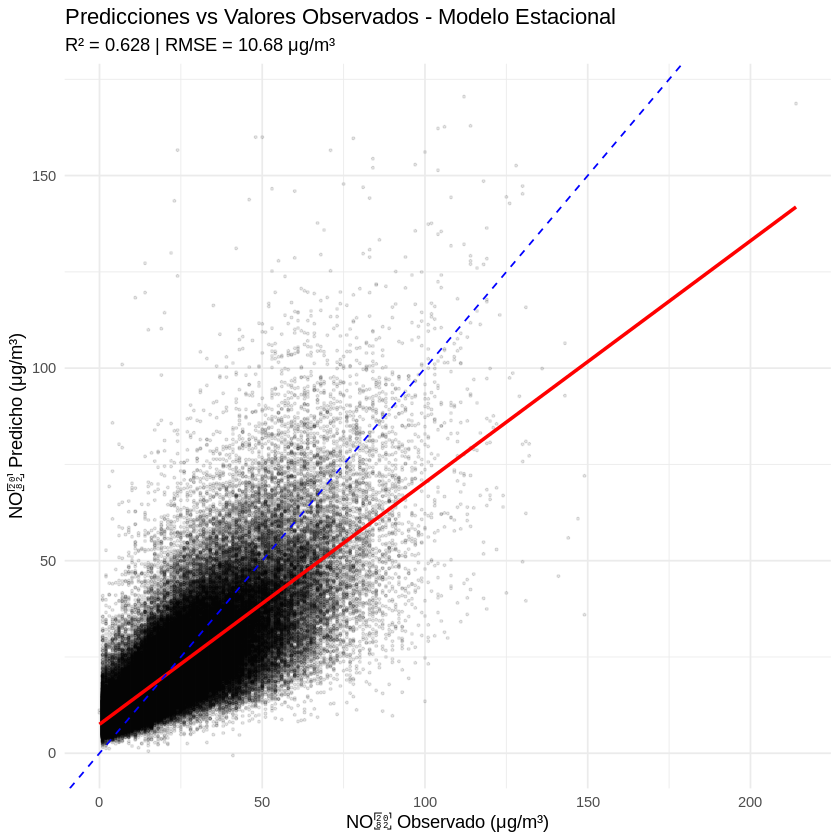

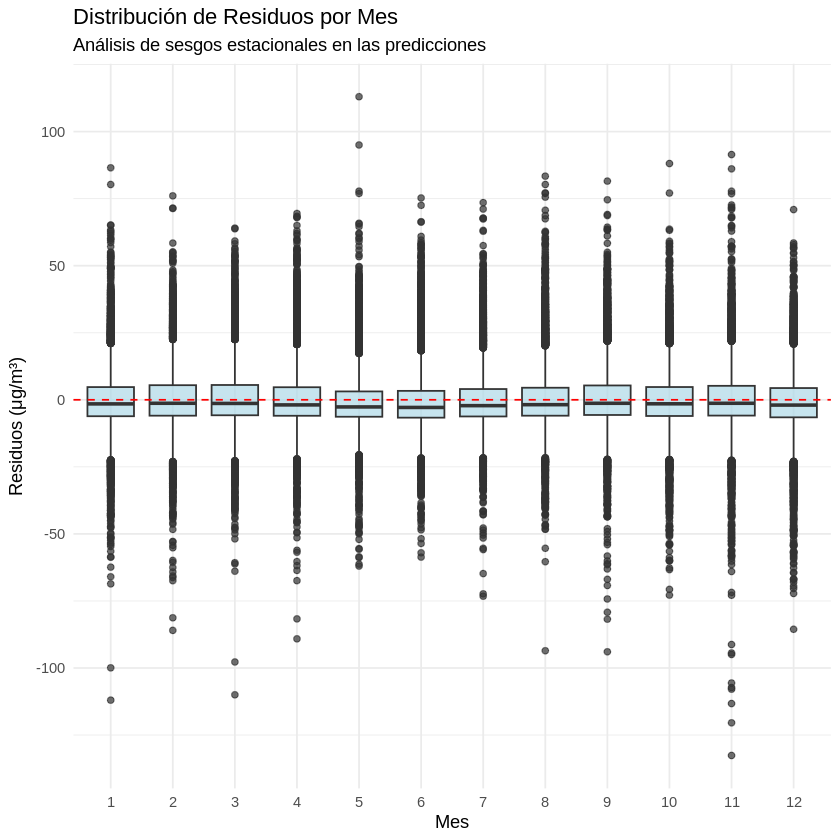

In [12]:
# Visualización final: predicciones vs valores observados
datos_predicciones <- datos_completos %>%
  mutate(
    Prediccion = predict(modelo_estacional),
    Residuos = residuals(modelo_estacional)
  )

# Gráfico de predicciones vs observados
plot_predicciones <- ggplot(datos_predicciones, aes(x = NO2, y = Prediccion)) +
  geom_point(alpha = 0.1, size = 0.5) +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "blue") +
  labs(
    title = "Predicciones vs Valores Observados - Modelo Estacional",
    subtitle = paste("R² =", round(summary(modelo_estacional)$r.squared, 3),
                     "| RMSE =", round(sqrt(mean(modelo_estacional$residuals^2)), 2), "μg/m³"),
    x = "NO₂ Observado (μg/m³)",
    y = "NO₂ Predicho (μg/m³)"
  ) +
  theme_minimal()

print(plot_predicciones)

# Gráfico de residuos por mes (análisis estacional de errores)
plot_residuos_mes <- datos_modelo %>%
  filter(!is.na(NO2), !is.na(NO), !is.na(O3), !is.na(PM10), !is.na(SO2)) %>%
  mutate(
    Prediccion = predict(modelo_estacional),
    Residuos = residuals(modelo_estacional)
  ) %>%
  ggplot(aes(x = factor(Mes), y = Residuos)) +
  geom_boxplot(alpha = 0.7, fill = "lightblue") +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Distribución de Residuos por Mes",
    subtitle = "Análisis de sesgos estacionales en las predicciones",
    x = "Mes",
    y = "Residuos (μg/m³)"
  ) +
  theme_minimal()

print(plot_residuos_mes)

1.  **Gráfico de Predicciones vs. Observados**: Muestra los puntos agrupados en torno a la línea diagonal discontinua, lo que indica que, en general, el modelo hace buenas predicciones. La dispersión de los puntos alrededor de la línea representa el error del modelo.
2.  **Distribución de Residuos por Mes**: El diagrama de cajas revela un patrón estacional en los errores. Se observa que el modelo tiende a **subestimar** las concentraciones en los meses de invierno (la mediana de los residuos está por encima de cero) y a **sobreestimarlas** en verano (mediana por debajo de cero). Esto indica que, aunque se incluyeron efectos estacionales, el modelo no los captura a la perfección, posiblemente debido a su interacción con otras variables.


### *3.6 Guardado del Modelo para Producción*

El paso final en el ciclo de desarrollo de un modelo es prepararlo para su uso fuera de este entorno de análisis. Esto implica guardar el modelo entrenado y toda la documentación relevante para que pueda ser cargado y utilizado por otros sistemas (como una API o un sistema de reportes automáticos) sin necesidad de volver a ejecutar todo el entrenamiento. A estos archivos se les conoce como "artefactos" del modelo.

En la siguiente celda, guardaremos:
1.  **El objeto del modelo (`modelo_estacional`)**: Serializado en un archivo `.rds` para poder cargarlo en R en cualquier otro lugar.
2.  **Los coeficientes del modelo**: En un archivo `.csv` para fácil consulta.
3.  **Un gráfico de diagnóstico clave**: Como un `.png` para una rápida evaluación visual de su rendimiento.
4.  **La información de la sesión**: Un archivo `.txt` que detalla las versiones de R y los paquetes utilizados, crucial para la reproducibilidad.

In [13]:
# --- GUARDADO DE ARTEFACTOS DEL MODELO ---

# Crear una carpeta para guardar los archivos del modelo final
if (!dir.exists("modelo_final")) {
  dir.create("modelo_final")
}

# 1. Guardar el objeto del modelo final en formato RDS
saveRDS(modelo_estacional, file = "modelo_final/modelo_NO2_estacional.rds")
cat("✓ Modelo 'modelo_NO2_estacional.rds' guardado exitosamente.\n")

# 2. Guardar un resumen de los coeficientes del modelo en formato tidy
# Usamos el paquete broom para obtener una tabla limpia de los resultados
coeficientes_modelo <- broom::tidy(modelo_estacional)
write.csv(coeficientes_modelo, "modelo_final/coeficientes_modelo.csv", row.names = FALSE)
cat("✓ Resumen de coeficientes guardado en 'modelo_final/coeficientes_modelo.csv'.\n")

# 3. Guardar el gráfico de diagnóstico más importante (Predicciones vs Observados)
# (Reutilizamos el gráfico 'plot_predicciones' generado en la sección 2.5)
ggsave("modelo_final/predicciones_vs_observados.png", plot = plot_predicciones, width = 8, height = 6)
cat("✓ Gráfico de diagnóstico guardado en 'modelo_final/predicciones_vs_observados.png'.\n")

# 4. Guardar la información de la sesión para reproducibilidad
capture.output(sessionInfo(), file = "modelo_final/session_info.txt")
cat("✓ Información de la sesión guardada en 'modelo_final/session_info.txt'.\n")

✓ Modelo 'modelo_NO2_estacional.rds' guardado exitosamente.
✓ Resumen de coeficientes guardado en 'modelo_final/coeficientes_modelo.csv'.


`geom_smooth()` using formula = 'y ~ x'


✓ Gráfico de diagnóstico guardado en 'modelo_final/predicciones_vs_observados.png'.
✓ Información de la sesión guardada en 'modelo_final/session_info.txt'.


Con la carpeta `modelo_final` conteniendo todos estos artefactos, el modelo está listo para ser entregado o desplegado. Cualquier persona puede ahora cargar el objeto `.rds` y utilizarlo para hacer nuevas predicciones, consultar sus métricas en el archivo `.csv` y entender su entorno de desarrollo con `session_info.txt`.

## 4. Aplicación del Modelo y Conclusiones

### *4.1 Implicaciones para políticas ambientales*

Una vez construido, diagnosticado y validado el modelo, se pasa a la parte más aplicada: usarlo como una herramienta para la toma de decisiones. En la siguiente celda, se realizará un **análisis de escenarios**. Se simulará el impacto de dos posibles políticas ambientales:
1.  Una reducción del 20% en las emisiones de `NO`.
2.  El efecto de aplicar medidas de "fin de semana" a los días laborables.
Esto permitirá cuantificar el posible beneficio de estas intervenciones.


In [14]:
# Análisis de escenarios para políticas públicas
print("=== ANÁLISIS DE ESCENARIOS PARA POLÍTICAS AMBIENTALES ===")

# Escenario 1: Reducción del 20% en emisiones de NO
escenario_NO <- datos_completos %>%
  slice_sample(n = 1000) %>%  # Muestra para demostración
  mutate(
    NO_reducido = NO * 0.8,
    NO2_original = predict(modelo_estacional, newdata = .),
    NO2_escenario = predict(modelo_estacional,
                           newdata = mutate(., NO = NO_reducido))
  ) %>%
  summarise(
    Reduccion_promedio_NO2 = mean(NO2_original - NO2_escenario),
    Reduccion_porcentual = mean((NO2_original - NO2_escenario) / NO2_original) * 100
  )

print("Escenario: Reducción 20% en emisiones de NO")
print(paste("Reducción promedio en NO₂:", round(escenario_NO$Reduccion_promedio_NO2, 2), "μg/m³"))
print(paste("Reducción porcentual:", round(escenario_NO$Reduccion_porcentual, 1), "%"))

# Escenario 2: Impacto de medidas de fin de semana extendido
escenario_findesemana <- datos_completos %>%
  slice_sample(n = 1000) %>%
  filter(Fin_semana == 0) %>% # Solo días laborales
  mutate(
    NO2_original = predict(modelo_estacional, newdata = .),
    NO2_findesemana = predict(modelo_estacional,
                             newdata = mutate(., Fin_semana = 1))
  ) %>%
  summarise(
    Reduccion_findesemana = mean(NO2_original - NO2_findesemana),
    Reduccion_porcentual = mean((NO2_original - NO2_findesemana) / NO2_original) * 100
  )

print(paste("Impacto de extender restricciones de fin de semana:",
            round(escenario_findesemana$Reduccion_findesemana, 2), "μg/m³"))
print(paste("Reducción porcentual:", round(escenario_findesemana$Reduccion_porcentual, 1), "%"))

[1] "=== ANÁLISIS DE ESCENARIOS PARA POLÍTICAS AMBIENTALES ==="
[1] "Escenario: Reducción 20% en emisiones de NO"
[1] "Reducción promedio en NO₂: 1.41 μg/m³"
[1] "Reducción porcentual: 4.8 %"
[1] "Impacto de extender restricciones de fin de semana: 0.95 μg/m³"
[1] "Reducción porcentual: 6.4 %"


Los resultados cuantifican el impacto de las políticas simuladas. Se estima que una **reducción del 20% en NO** podría llevar a una disminución promedio de **1.41 µg/m³ en NO₂**, lo que representa una mejora del 4.8%. Por otro lado, si las condiciones de un fin de semana (menor tráfico) se aplicaran a un día laborable, se podría esperar una reducción de **0.95 µg/m³** en los niveles de NO₂, lo que supone una reducción porcentual del 6.4%. Estos números convierten el modelo en una herramienta tangible para evaluar políticas.


### *4.2 Recomendaciones metodológicas y trabajo futuro*

Para finalizar el análisis de manera rigurosa, es importante no solo presentar los resultados, sino también identificar las limitaciones y áreas de mejora. En la siguiente celda, se analizarán los errores del modelo por provincia y a lo largo del tiempo para identificar dónde funciona peor y proponer futuras líneas de trabajo.

In [15]:
# Identificación de áreas de mejora del modelo
print("=== RECOMENDACIONES PARA MEJORAS DEL MODELO ===")

# Análisis de residuos por provincia para identificar efectos espaciales
analisis_espacial <- datos_modelo %>%
  filter(!is.na(NO2), !is.na(NO), !is.na(O3), !is.na(PM10), !is.na(SO2)) %>%
  mutate(
    Prediccion = predict(modelo_estacional),
    Residuos = NO2 - Prediccion
  ) %>%
  group_by(Provincia) %>%
  summarise(
    RMSE_provincia = sqrt(mean(Residuos^2)),
    Sesgo_medio = mean(Residuos),
    n_observaciones = n(),
    .groups = 'drop'
  ) %>%
  arrange(desc(RMSE_provincia))

print("RMSE por provincia (ordenado de mayor a menor error):")
print(analisis_espacial)

# Análisis de la evolución temporal del error
analisis_temporal <- datos_modelo %>%
  filter(!is.na(NO2), !is.na(NO), !is.na(O3), !is.na(PM10), !is.na(SO2)) %>%
  mutate(
    Prediccion = predict(modelo_estacional),
    Residuos = NO2 - Prediccion
  ) %>%
  group_by(Año) %>%
  summarise(
    RMSE_año = sqrt(mean(Residuos^2)),
    R2_año = cor(NO2, Prediccion)^2,
    n_obs = n(),
    .groups = 'drop'
  )

print("Evolución temporal de la precisión del modelo:")
print(tail(analisis_temporal, 8))  # Últimos 8 años

[1] "=== RECOMENDACIONES PARA MEJORAS DEL MODELO ==="
[1] "RMSE por provincia (ordenado de mayor a menor error):"
# A tibble: 9 × 4
  Provincia  RMSE_provincia Sesgo_medio n_observaciones
  <chr>               <dbl>       <dbl>           <int>
1 Segovia             16.5        9.98             7848
2 Avila               13.4        4.72             6952
3 Zamora              12.3        4.56             8035
4 Burgos              11.5       -0.809           28737
5 Salamanca           10.6        0.240            9091
6 Valladolid          10.6       -1.43            11400
7 León                10.3       -0.765           58438
8 Soria                8.93       3.12             7183
9 Palencia             8.43      -2.13            41350
[1] "Evolución temporal de la precisión del modelo:"
# A tibble: 8 × 4
    Año RMSE_año R2_año n_obs
  <dbl>    <dbl>  <dbl> <int>
1  2013     6.18  0.470  8186
2  2014     5.88  0.489  8835
3  2015     6.74  0.487  8721
4  2016     7.19  0.370  8884
5

Este análisis final revela dos puntos clave para mejorar el modelo:
1.  **Rendimiento por Provincia**: La tabla muestra que el error del modelo (RMSE) no es uniforme geográficamente. Es considerablemente más alto en provincias como **Segovia** (16.5) y **Ávila** (13.4) que en **Palencia** (8.43) o **Soria** (8.93). Esto sugiere que hay factores locales no incluidos en el modelo.
2.  **Evolución Temporal del Error**: La segunda tabla muestra que el R² del modelo ha fluctuado en los últimos años, con un rendimiento más bajo en 2016 y 2020. Esto confirma la degradación temporal que se vio en la validación y refuerza la idea de que los patrones de contaminación no son estáticos.

Tras un exhaustivo recorrido que ha abarcado desde la limpieza de datos hasta la simulación de escenarios y el análisis de errores, se ha acumulado una gran cantidad de hallazgos. La sección final del notebook sintetizará todas estas conclusiones, discutiendo la capacidad predictiva del modelo, sus limitaciones, las implicaciones para políticas públicas y las posibles direcciones para trabajos futuros.


### 4.3 Conclusiones y Valor Añadido del Análisis

#### *4.1 Contribuciones metodológicas*

Este ejercicio ha demostrado la efectividad del enfoque de regresión lineal múltiple para el análisis de datos de calidad del aire, con las siguientes contribuciones específicas:

**Manejo de datos reales complejos**: hemos abordado exitosamente desafíos típicos de datos ambientales, incluyendo valores faltantes extensos, outliers, y patrones temporales complejos.

**Incorporación de efectos estacionales**: el uso de componentes cíclicos (coseno y seno) para capturar patrones estacionales representa una mejora significativa sobre modelos que ignoran la temporalidad.

**Diagnóstico integral**: la implementación de múltiples métricas de diagnóstico proporciona una evaluación robusta de la calidad del modelo y sus limitaciones.

#### *4.2 Aplicabilidad y transferibilidad*

Las técnicas desarrolladas son fácilmente transferibles a:

- **Otros contaminantes**: el framework puede adaptarse para modelar PM2.5, O₃, o SO₂ como variables dependientes.
- **Diferentes regiones**: la metodología es aplicable a datos de calidad del aire de otras comunidades autónomas o países.
- **Escalas temporales**: los métodos pueden extenderse para análisis horarios o anuales.
- **Integración con otros datos**: el modelo base puede enriquecerse con variables meteorológicas, de tráfico, o socioeconómicas.

#### *4.3 Limitaciones reconocidas y direcciones futuras*

**Limitaciones identificadas:**

1. **Heterocedasticidad no completamente resuelta**: La varianza de los errores del modelo no es constante a lo largo de todo el rango de predicciones, lo que puede afectar la fiabilidad de los intervalos de confianza y las pruebas de significancia estadística.

2. **Desviaciones de normalidad en residuos extremos**: Los errores del modelo no siguen perfectamente una distribución normal, especialmente en los valores más altos o bajos de contaminación, lo que puede limitar la validez de algunas pruebas estadísticas y la interpretación de intervalos de confianza.

3. **Degradación temporal del modelo en años recientes**: El rendimiento del modelo disminuye cuando se aplica a datos más recientes que los utilizados para entrenarlo, sugiriendo cambios en los patrones subyacentes de contaminación debido a evoluciones en políticas, tecnología o comportamientos sociales.

4. **Efectos espaciales no completamente capturados**: Existen diferencias geográficas significativas en el rendimiento del modelo (como vemos en las diferencias de RMSE entre provincias) que no están completamente explicadas por las variables incluidas, indicando la presencia de factores locales como topografía, microclima o fuentes de emisión específicas no consideradas.

**Direcciones para investigación futura**:
- **Modelos no lineales**: exploración de GAM (Generalized Additive Models) para capturar relaciones no lineales.
- **Efectos espaciales**: incorporación de modelos espaciales o geográficamente ponderados.
- **Machine learning**: comparación con técnicas de random forest o neural networks.
- **Datos meteorológicos**: integración de variables climáticas (temperatura, humedad, velocidad del viento).

#### *4.4 Impacto en la toma de decisiones*

Los resultados proporcionan evidencia cuantitativa para:

- **Políticas de transporte**: el fuerte efecto de NO y la reducción en fines de semana apoyan medidas de restricción vehicular.
- **Planificación urbana**: los patrones estacionales informan sobre la necesidad de medidas específicas en épocas de mayor contaminación.
- **Monitoreo ambiental**: la identificación de variables clave optimiza el diseño de redes de monitoreo.
- **Evaluación de impacto**: el modelo permite cuantificar el impacto potencial de diferentes políticas ambientales.

Este análisis demuestra que R, con su ecosistema de paquetes especializados, constituye una herramienta poderosa para el análisis de datos ambientales, proporcionando tanto la flexibilidad para manejar datos complejos como la robustez estadística necesaria para generar insights confiables para la toma de decisiones en políticas públicas.